In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

In [11]:
r = 102317240
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print(a_r)
print(b_r)

2.0
0.3


In [12]:
df = pd.read_csv('/kaggle/input/india-air-quality-data/data.csv', encoding='latin1', low_memory=False)
x = pd.to_numeric(df['no2'], errors='coerce').dropna().values
z = x + a_r * np.sin(b_r * x)

z_mean = z.mean()
z_std = z.std()
z_norm = (z - z_mean) / z_std

In [13]:
noise_dim = 5

generator = Sequential()
generator.add(Input(shape=(noise_dim,)))
generator.add(Dense(16, activation='relu'))
generator.add(Dense(16, activation='relu'))
generator.add(Dense(1))

discriminator = Sequential()
discriminator.add(Input(shape=(1,)))
discriminator.add(Dense(16, activation='relu'))
discriminator.add(Dense(16, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002), metrics=['accuracy'])
discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake = generator(gan_input)
gan_output = discriminator(fake)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002))

2026-02-10 11:08:53.670816: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
batch_size = 64
epochs = 1000

real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

d_losses = []
g_losses = []

for epoch in range(epochs):
    idx = np.random.randint(0, z_norm.shape[0], batch_size)
    real_samples = z_norm[idx].reshape(-1, 1)

    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    fake_samples = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    g_loss = gan.train_on_batch(noise, real_labels)

    d_losses.append(d_loss[0])
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(epoch, d_loss[0], g_loss)

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 0.6678807 0.6929982
100 0.6791092 0.6847063
200 0.69449675 0.65693784
300 0.71260905 0.6268483
400 0.7328681 0.5966289
500 0.7570373 0.565346
600 0.7859404 0.53275716
700 0.8200547 0.50023043
800 0.85878116 0.4686327
900 0.90129876 0.4388283


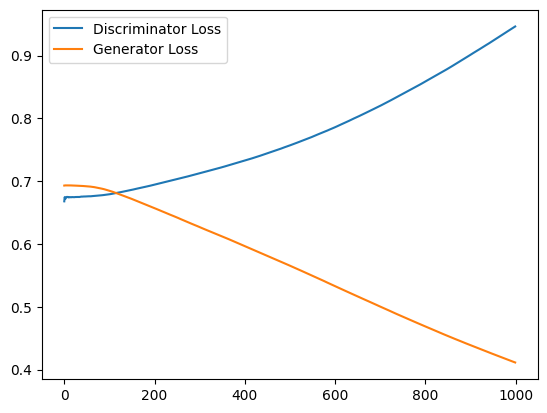

In [15]:
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.legend()
plt.show()

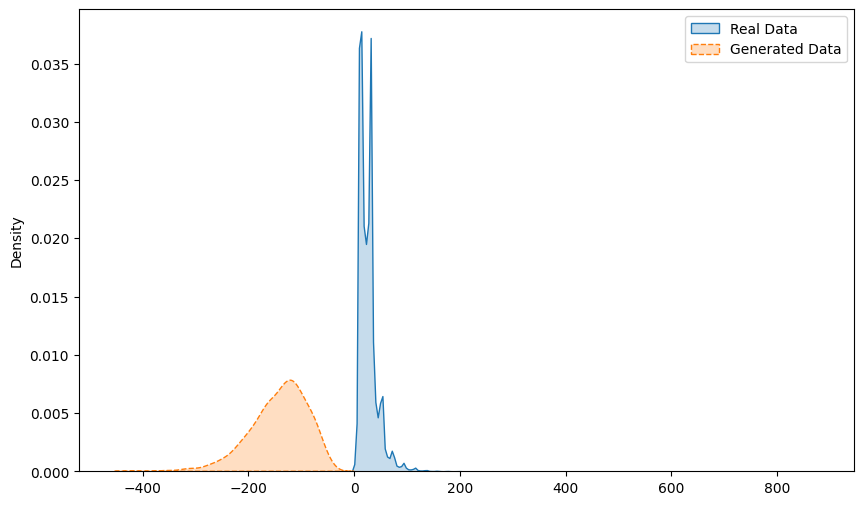

In [16]:
num_samples = 2000
noise = np.random.normal(0, 1, (num_samples, noise_dim))
generated_z_norm = generator.predict(noise, verbose=0)
generated_z = generated_z_norm * z_std + z_mean

plt.figure(figsize=(10, 6))
sns.kdeplot(z, label='Real Data', fill=True)
sns.kdeplot(generated_z.flatten(), label='Generated Data', fill=True, linestyle="--")
plt.legend()
plt.show()